# COMP9727 Recommender Systems <br> <br>Assignment – Content-Based Music Recommendation
**Name**: Yuhui Wang <br> 
**zID**: z5557746  

## Part1. Topic Classification

In [7]:
import pandas as pd
import nltk
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, ComplementNB
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score

In [8]:
df = pd.read_csv("dataset.tsv", sep='\t')
pd.set_option('display.width', 180)
pd.set_option('display.max_colwidth', 140)
print(df.head(20))

                             artist_name                                               track_name  release_date    genre  \
0                                 loving                                        the not real lake          2016     rock   
1                                incubus                                          into the summer          2019     rock   
2                              reignwolf                                                 hardcore          2016    blues   
3                   tedeschi trucks band                                                   anyhow          2016    blues   
4   lukas nelson and promise of the real                                        if i started over          2017    blues   
5                                tia ray                                             just my luck          2018     jazz   
6                             rebelution                                                trap door          2018   reggae   
7       

In [9]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))
sci_stop_words = set(list(ENGLISH_STOP_WORDS)) # scikit-learn stopwords

# Define preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)     # Keep @, - and '
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [ps.stem(word) for word in tokens]
    return ' '.join(tokens)

def preprocess_text_without_lower(text):
    text = re.sub(r'[^\w\s@\-\']', '', text)     # Keep @, - and '
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [ps.stem(word) for word in tokens]
    return ' '.join(tokens)

def preprocess_text_without_re(text):
    text = text.lower()
    text = re.sub(r'[^\w\s@\-\']', '', text)     # Keep @, - and '
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [ps.stem(word) for word in tokens]
    return ' '.join(tokens)

def preprocess_text_with_sci_stopword(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)     # Keep @, - and '
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in sci_stop_words]
    tokens = [ps.stem(word) for word in tokens]
    return ' '.join(tokens)

def preprocess_text_without_stopword(text):
    text = text.lower()
    text = re.sub(r'[^\w\s@\-\']', '', text)     # Keep @, - and '
    tokens = word_tokenize(text)
    tokens = [ps.stem(word) for word in tokens]
    return ' '.join(tokens)

def preprocess_text_without_stem(text):
    text = text.lower()
    text = re.sub(r'[^\w\s@\-\']', '', text)     # Keep @, - and '
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jennifer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jennifer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jennifer/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Part1-1
(i)the regex might remove too many special characters.
I try to keep some special characters like @, -, ' with r'[^\w\s@-']'<br>
(ii) the evaluation is based on only one training test split rather than using cross-validation.I use cross validation and cross_val_score to validate the accuracy later.

In [18]:
df['document'] = df['artist_name'] + ' ' + df['track_name'] + ' ' + df['release_date'].astype(str) + ' ' + df['genre'] + ' ' + df['lyrics'] # + ' ' + df['topic']
# Drop duplicates and missing values
df = df.drop_duplicates()
df = df.dropna()
# print(df.info())

# Apply preprocessing to each document
# Test different preprocessing steps
# df['document'] = df['document'].apply(preprocess_text)                   # acc: 0.786
# df['document'] = df['document'].apply(preprocess_text_without_lower)     # acc: 0.786
# df['document'] = df['document'].apply(preprocess_text_without_special)   # acc: 0.786
# df['document'] = df['document'].apply(preprocess_text_without_stopword)  # acc: 0.783
# df['document'] = df['document'].apply(preprocess_text_with_sci_stopword) # acc: 0.781
df['document'] = df['document'].apply(preprocess_text_without_stem)      # acc: 0.790

# print(df['document'])

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['document'])

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, df['topic'], test_size=0.2, random_state=42)


bnb = BernoulliNB()
# Use cross validation to replace train-test split
cv_scores = cross_val_score(bnb, X, df['topic'], cv=5, scoring='accuracy')
print(f"BNB mean acc: {cv_scores.mean():.3f}" )

mnb = MultinomialNB()
cv_scores = cross_val_score(mnb, X, df['topic'], cv=5, scoring='accuracy')
print(f"MNB mean acc: {cv_scores.mean():.3f}" )

BNB mean acc: 0.527
MNB mean acc: 0.790


### Part1-2
According to my experiments above, the best performance (MNB accuracy = 0.79) was achieved **without stemming**. the special characters does not affect the result too much, the result on different stopword lists(NLTK and scikit-learn) are the same, lowcasing has no obvious effect, and not stemming can increase accuracy.

### Part1-3
Micro/Macro-Averaging are used for multiple classification. Micro-average is dominated by larger classes and macro-average is dominated by smaller classes which is useful for imbalanced classes. Therefore I use precision_macro and recall_macro here.

The result table shows **MultinomialNB** is better than BernoulliNB.

In [9]:
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_macro',
    'recall': 'recall_macro'
}
bnb = BernoulliNB()
bnb_scores = cross_validate(bnb, X, df['topic'], cv=5, scoring=scoring)

# print(f"BernoulliNB mean acc: {cv_scores.mean():.3f}" )

mnb = MultinomialNB()
mnb_scores = cross_validate(mnb, X, df['topic'], cv=5, scoring=scoring)
# print(f"MultinomialNB mean acc: {cv_scores.mean():.3f}" )

results = pd.DataFrame({
    'BNB': [bnb_scores['test_accuracy'].mean(), 
            bnb_scores['test_precision'].mean(),
            bnb_scores['test_recall'].mean(),],
    'MNB': [mnb_scores['test_accuracy'].mean(),
            mnb_scores['test_precision'].mean(),
            mnb_scores['test_recall'].mean(),]
}, index=['Accuracy', 'Precision', 'Recall'])

print(results.round(4))

              BNB     MNB
Accuracy   0.5270  0.7899
Precision  0.3612  0.7519
Recall     0.3777  0.7015


/opt/anaconda3/envs/AI/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/AI/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


/opt/anaconda3/envs/AI/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/AI/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/AI/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


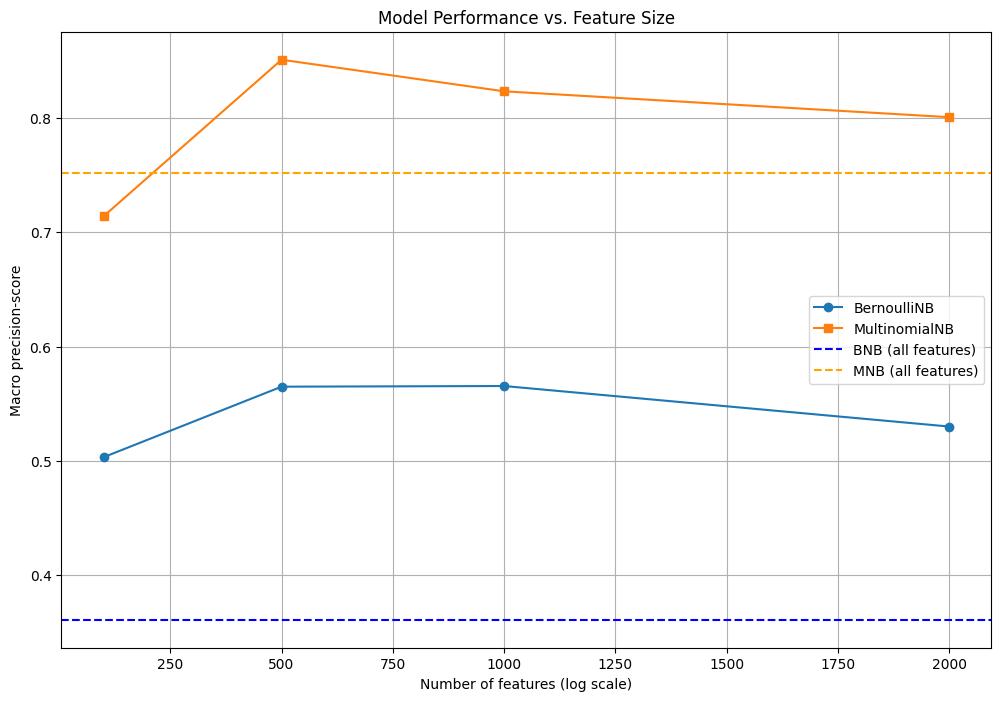

In [22]:
feature_sizes = [100, 500, 1000, 2000, 'all']
bnb_scores = []
mnb_scores = []

for n_features in feature_sizes:
    vectorizer = CountVectorizer(max_features=None if n_features == 'all' else n_features)
    X = vectorizer.fit_transform(df['document'])
    y = df['topic']
    # Cross-validate (5-fold)
    bnb_score = cross_val_score(bnb, X, y, cv=5, scoring='precision_macro').mean()
    mnb_score = cross_val_score(mnb, X, y, cv=5, scoring='precision_macro').mean()
    
    bnb_scores.append(bnb_score)
    mnb_scores.append(mnb_score)

feature_sizes[-1] = len(vectorizer.get_feature_names_out())

plt.figure(figsize=(12, 8))
plt.plot(feature_sizes[:-1], bnb_scores[:-1], 'o-', label='BernoulliNB')
plt.plot(feature_sizes[:-1], mnb_scores[:-1], 's-', label='MultinomialNB')
plt.axhline(y=bnb_scores[-1], color='blue', linestyle='--', label='BNB (all features)')
plt.axhline(y=mnb_scores[-1], color='orange', linestyle='--', label='MNB (all features)')
# plt.xscale('log')
plt.xlabel('Number of features (log scale)')
plt.ylabel('Macro precision-score')
plt.title('Model Performance vs. Feature Size')
plt.legend()
plt.grid(True)
plt.show()

### Part1-4
According to my experiments above, we can see that the best N value is 500 from the graph.

### Part1-5
We choose Complement Naive Bayes here. It is said to be an adaption of the standard Multinomial naive Bayes and particularly suited for imbalanced datasets.  
We set the max feature to be N=500.  
The metrics comparison shows that **MultinomialNB** is better than BernoulliNB and ComplementNB.  

In [25]:
vectorizer = CountVectorizer(max_features=500)

X = vectorizer.fit_transform(df['document'])
y = df['topic']

bnb = BernoulliNB()
bnb_scores = cross_validate(bnb, X, df['topic'], cv=5, scoring=scoring)

# print(f"BernoulliNB mean acc: {cv_scores.mean():.3f}" )

mnb = MultinomialNB()
mnb_scores = cross_validate(mnb, X, df['topic'], cv=5, scoring=scoring)
# print(f"MultinomialNB mean acc: {cv_scores.mean():.3f}" )

cnb = ComplementNB()
cnb_scores = cross_validate(cnb, X, df['topic'], cv=5, scoring=scoring)

results = pd.DataFrame({
    'BNB': [bnb_scores['test_accuracy'].mean(), 
            bnb_scores['test_precision'].mean(),
            bnb_scores['test_recall'].mean(),],
    'MNB': [mnb_scores['test_accuracy'].mean(),
            mnb_scores['test_precision'].mean(),
            mnb_scores['test_recall'].mean(),],
    'CNB': [cnb_scores['test_accuracy'].mean(), 
            cnb_scores['test_precision'].mean(),
            cnb_scores['test_recall'].mean(),],
}, index=['Accuracy', 'Precision', 'Recall'])

print(results.round(4))

              BNB     MNB     CNB
Accuracy   0.6561  0.8662  0.8608
Precision  0.5649  0.8508  0.8546
Recall     0.5544  0.8451  0.8227


In [26]:
mnb.fit(X, df['topic'])

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


## Part 2. Recommendation Methods

### Part2-1

In [34]:
df_train = df[:750]
df_test = df[750:1000]

In [35]:
from collections import defaultdict
topic_to_docs = defaultdict(list)
for idx, row in df_train.iterrows():  # train_data contains Weeks 1-3 (750 songs)
    topic_to_docs[row['topic']].append(row['document'])

# topic_vectorizers = {}
topic_matrices = {}
tfidf_vectorizer = TfidfVectorizer(stop_words="english")
X = tfidf_vectorizer.fit_transform(df['document'])

for topic in sorted(topic_to_docs.keys()):
    matrix = tfidf_vectorizer.transform(topic_to_docs[topic])
    topic_matrices[topic] = matrix
    print(f"Topic {topic}: {len(topic_to_docs[topic])} songs, {matrix.shape[1]} features")


Topic dark: 246 songs, 9865 features
Topic emotion: 42 songs, 9865 features
Topic lifestyle: 92 songs, 9865 features
Topic personal: 187 songs, 9865 features
Topic sadness: 183 songs, 9865 features


In [37]:
# Load users interest keywords
def load_user_interests(user_file):
    interests = defaultdict(list)
    with open(user_file) as f:
        f.readline()
        for line in f:
            topic, keywords = line.strip().split('\t')
            interests[topic] = [kw.lower() for kw in keywords.split()]
    return interests

user1_interests = load_user_interests('user1.tsv')
user2_interests = load_user_interests('user2.tsv')
user3_interests = load_user_interests('user3.tsv')

print(user1_interests)
print(user2_interests)
print(user3_interests)

defaultdict(<class 'list'>, {'dark': ['fire,', 'enemy,', 'pain,', 'storm,', 'fight'], 'sadness': ['cry,', 'alone,', 'heartbroken,', 'tears,', 'regret'], 'personal': ['dream,', 'truth,', 'life,', 'growth,', 'identity'], 'lifestyle': ['party,', 'city,', 'night,', 'light,', 'rhythm'], 'emotion': ['love,', 'memory,', 'hug,', 'kiss,', 'feel']})
defaultdict(<class 'list'>, {'sadness': ['lost,', 'sorrow,', 'goodbye,', 'tears,', 'silence'], 'emotion': ['romance,', 'touch,', 'feeling,', 'kiss,', 'memory']})
defaultdict(<class 'list'>, {'dark': ['"fire,', 'pain,', 'storm,', 'star"'], 'sadness': ['"cry,', 'alone,', 'heartbroken,', 'tears,', 'sorrow,', 'goodbye"'], 'personal': ['"dream,', 'truth,', 'life,', 'growth,', 'identity"'], 'lifestyle': ['"party,', 'city,', 'night,', 'light,', 'rhythm"'], 'emotion': ['"love,', 'memory,', 'kiss,', 'hate"']})


In [39]:
def build_user_profile(data, user_interests, vectorizer, classifier, top_n=10, M=10):
    X = vectorizer.transform(data['document'])
    pred_topics = classifier.predict(X)
    
    # Filter the songs that users like for each topic
    profile_docs = defaultdict(list)
    for idx, row in data.iterrows():
        if idx == 750:
            break
        pred_topic = pred_topics[idx]

        if pred_topic in user_interests:
            # Calculate the similarity between the song and the user's keywords
            kw_vector = tfidf_vectorizer.transform([' '.join(user_interests.get(pred_topic, []))])
            song_vector = tfidf_vectorizer.transform([row['document']])
            similarity = cosine_similarity(song_vector, kw_vector)[0][0]
            
            # Record similarity is used for sorting
            profile_docs[pred_topic].append((similarity, row['document']))

    # Select the Top-N songs for each topic and merge the documents
    profile_vectors = {}
    profile_words = {}
    for topic in profile_docs:
        # Sort in descending order of similarity
        sorted_songs = sorted(profile_docs[topic], key=lambda x: x[0], reverse=True)
        liked_songs = []
        topic_kws = set(user_interests.get(topic, []))
        # print(f"Topic {topic} kws:", ' '.join(topic_kws))
        for sim, doc in sorted_songs[:top_n]:
            song_words = set(doc.lower().split())
            if len(topic_kws & song_words) > 0:
                liked_songs.append((sim, doc))
        
        # Merge the Top-N songs into one document
        combined_doc = ' '.join([doc for (sim, doc) in liked_songs])
        # generate TF-IDF vector
        profile_vectors[topic] = tfidf_vectorizer.transform([combined_doc])
        
        # print the keywords for each topic
        feature_names = tfidf_vectorizer.get_feature_names_out()
        sorted_idx = np.argsort(profile_vectors[topic].toarray())[0][-M:][::-1]
        top_words = [feature_names[i] for i in sorted_idx]
        profile_words[topic] = top_words
        print(f"【{topic}】profile top 20 words：")
        print(", ".join(top_words) + "\n")
    
    return profile_vectors, profile_words

print("User 1 profile:")
user1_profile, user1_words = build_user_profile(df_train, user1_interests, vectorizer, mnb, M=20)
print("User 2 profile:")
user2_profile, user2_words = build_user_profile(df_train, user2_interests, vectorizer, mnb, M=20)
print("User 3 profile:")
user3_profile, user3_words = build_user_profile(df_train, user3_interests, vectorizer, mnb, M=20)

User 1 profile:
【dark】profile top 20 words：
fight, bleed, gon, na, battle, brother, surround, tell, divide, machine, come, unite, white, right, honour, foes, stand, kill, redneck, lead

【lifestyle】profile top 20 words：
sing, song, version, pin, kingdom, tower, rhythm, hour, girl, letter, write, midnight, like, kinda, hopeful, favorite, radio, think, loud, bout

【sadness】profile top 20 words：
wish, lay, greater, regret, think, hand, leave, place, beg, wider, cause, blame, stall, want, tangle, bathroom, head, windows, hold, screen

【emotion】profile top 20 words：
good, feel, lips, doin, kiss, want, coast, right, dirty, know, na, goodbye, hold, gon, control, south, like, east, baby, uhhuh

【personal】profile top 20 words：
ﬁnished, fraction, framework, frame, frailty, frail, fragment, fragile, fracture, fractal, fossil, foxes, fox, fourth, fountains, fountain, foundation, foul, franchiser, frankie

User 2 profile:
【sadness】profile top 20 words：
break, heart, crash, spin, like, cut, dark, apa

### Part2-1 Comment
we can see first several keywords in each topic are more reasonable for each topic. This is true for user3, too.

### Part2-2 

In [41]:
def build_profile_variants(data, interests, vectorizer, classifier, top_n=10, m_values=[5,10,20]):
    """ build profiles with different M keywords for each topic"""
    profiles = {}
    
    # predict topic and filter correct topic songs
    X = vectorizer.transform(data['document'])
    pred_topics = classifier.predict(X)
    # correct_preds = data[pred_topics == data['topic']]
    
    for m in m_values:
        profile_docs = defaultdict(list)
        for idx, row in data.iterrows():
            if idx == 750:
                break
            pred_topic = pred_topics[idx]

            if pred_topic in interests:
                # Calculate the similarity between the song and the user's keywords
                kw_vector = tfidf_vectorizer.transform([' '.join(interests.get(pred_topic, []))])
                song_vector = tfidf_vectorizer.transform([row['document']])
                similarity = cosine_similarity(song_vector, kw_vector)[0][0]
                
                # Record similarity is used for sorting
                profile_docs[pred_topic].append((similarity, row['document']))
        
        # Select the Top-N songs for each topic and merge the documents
        profile_vectors = {}
        for topic in profile_docs:
            # Sort in descending order of similarity
            sorted_songs = sorted(profile_docs[topic], key=lambda x: x[0], reverse=True)
            liked_songs = []
            topic_kws = set(interests.get(topic, []))
            for sim, doc in sorted_songs[:top_n]:
                song_words = set(doc.lower().split())
                if len(topic_kws & song_words) > 0:
                    liked_songs.append((sim, doc))
            
            # Merge the favorite songs into one document
            combined_doc = ' '.join([doc for (sim, doc) in liked_songs])
            # generate TF-IDF vector
            profile_vectors[topic] = tfidf_vectorizer.transform([combined_doc])
            
            profiles[f'm={m}'] = profile_vectors
    return profiles

# generate portraits according todifferent M value
profile1_variants = build_profile_variants(df_train, user1_interests, vectorizer, mnb, top_n=10, m_values=[5,10,20])
profile2_variants = build_profile_variants(df_train, user2_interests, vectorizer, mnb, top_n=10, m_values=[5,10,20])
print(profile1_variants)


{'m=5': {np.str_('dark'): <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 260 stored elements and shape (1, 9865)>, np.str_('lifestyle'): <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 97 stored elements and shape (1, 9865)>, np.str_('sadness'): <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 102 stored elements and shape (1, 9865)>, np.str_('emotion'): <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 256 stored elements and shape (1, 9865)>, np.str_('personal'): <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 0 stored elements and shape (1, 9865)>}, 'm=10': {np.str_('dark'): <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 260 stored elements and shape (1, 9865)>, np.str_('lifestyle'): <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 97 stored elements and shape (1, 9865)>, np.str_('sadness'): <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 102 stored elements and shape (1, 98

### Part2-2  Choose N and M value. Use tf-idf vector cos similarity between user profile vectors and song vectors
I choose N=10 for each topic so that there are at most 50 songs for user to choose.  
I use precision, recall and f1 as the metrics.  
For different M size, we test 5, 10 and 20.  
I use tf-idf vector cos similarity between user profile vectors and song vectors for recommending and check the intersection of keywords of each topic with the document words.

Test m: 5
Test m: 10
Test m: 20
Test m: 5
Test m: 10
Test m: 20
=== metrics ===
         precision@10  recall@10     f1@10
m_value                                   
m=20             0.86       0.94  0.859559
m=10             0.84       0.94  0.833918
m=5              0.80       0.98  0.833918


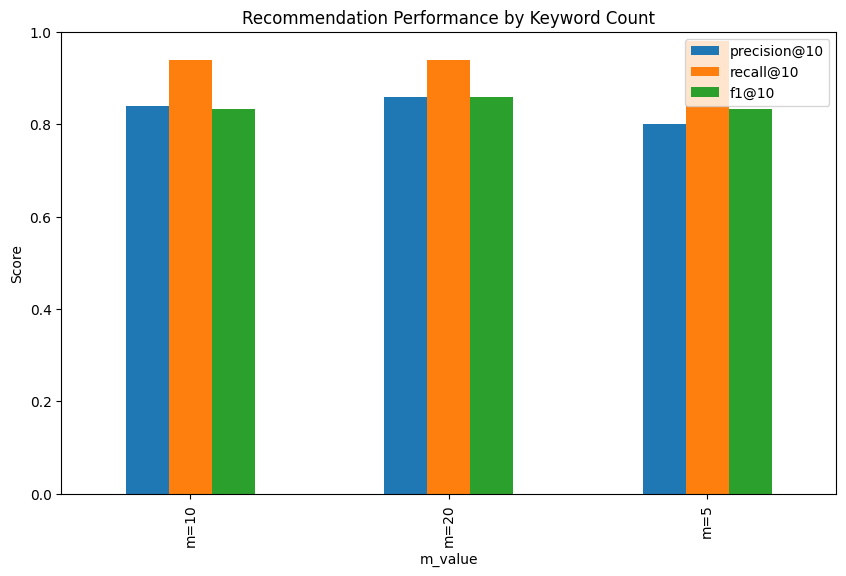

=== metrics ===
         precision@10  recall@10     f1@10
m_value                                   
m=20         1.000000       0.95  0.973684
m=10         0.812500       0.95  0.858300
m=5          0.571429       1.00  0.625000


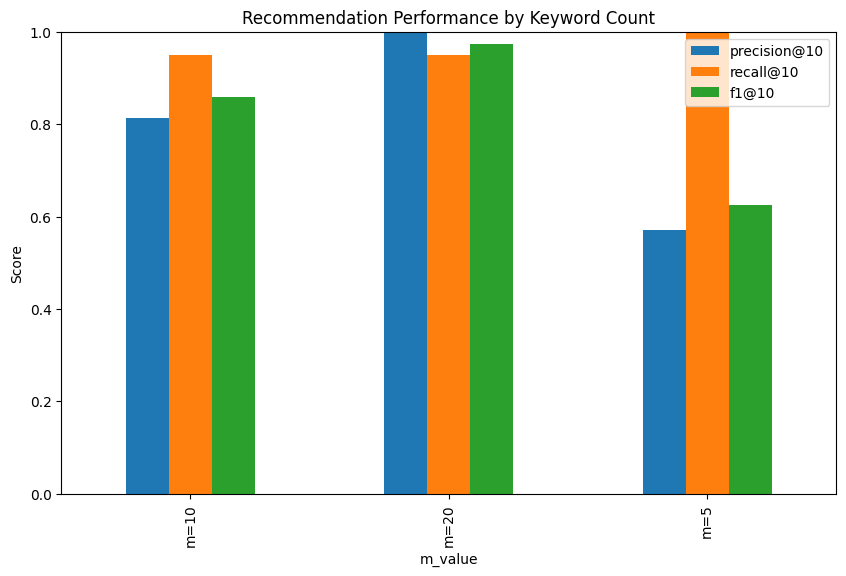

In [43]:
#Simulation Recommendation and Evaluation

def evaluate_recommendations(test_data, profiles, vectorizer, classifier, N=10):
    results = []
    
    X_test = vectorizer.transform(test_data['document'])
    # print(X_test.shape)
    test_pred_topics = classifier.predict(X_test)
    # print(test_pred_topics.shape)
    
    for m_name, profile in profiles.items():
        interests = {}
        M = int(m_name[2:])
        print("Test m:", M)
        for topic in profile:
            feature_names = tfidf_vectorizer.get_feature_names_out()
            sorted_idx = np.argsort(profile[topic].toarray())[0][-M:][::-1]
            top_words = [feature_names[i] for i in sorted_idx]
            interests[topic] = top_words[:M]

        recommendations = defaultdict(list)
        for i, (_, row) in enumerate(test_data.iterrows()):
            pred_topic = test_pred_topics[i]
            if pred_topic in profile:
                kw_vector = tfidf_vectorizer.transform([' '.join(interests.get(pred_topic, []))])
                song_vec = tfidf_vectorizer.transform([row['document']])
                
                similarity = cosine_similarity(song_vec, kw_vector)[0][0]
                recommendations[pred_topic].append((similarity, row))
        
        # print("M", m_name)
        # Evaluate the recommendations for each topic
        for topic in recommendations:
            # Sort by similarity to take the top 10
            top_songs = sorted(recommendations[topic], key=lambda x: x[0], reverse=True)[:N]
            
            # Check whether the user's interest keywords have been hit
            y_true = []
            y_pred = []
            topic_kws = set(interests.get(topic, []))
            # print(f'Topic {topic} kws: {" ".join(topic_kws)}')
            
            for sim, row in top_songs:
                song_words = set(row['document'].lower().split())
                if len(song_words & topic_kws) > 0:
                    y_true.append(1)
                else:
                    y_true.append(0)

                if topic == row['topic']:
                    y_pred.append(1)
                else:
                    y_pred.append(0)
            
            if len(y_true) > 0:
                precision = precision_score(y_true, y_pred, zero_division=0)
                recall = recall_score(y_true, y_pred, zero_division=0)
                f1 = f1_score(y_true, y_pred, zero_division=0)
                
                results.append({
                    'm_value': m_name,
                    'topic': topic,
                    'precision@10': precision,
                    'recall@10': recall,
                    'f1@10': f1,
                    # 'recommendations': [s[1]['document'] for s in top_songs]
                })
    
    return pd.DataFrame(results)

eval1_results = evaluate_recommendations(df_test, profile1_variants, vectorizer, mnb)
eval2_results = evaluate_recommendations(df_test, profile2_variants, vectorizer, mnb)

# 7. analyze the result and print metrics
def analyze_results(results_df):
    summary = results_df.groupby('m_value')[['precision@10','recall@10','f1@10']].mean()
    
    print("=== metrics ===")
    print(summary.sort_values('precision@10', ascending=False))
    
    summary.plot(kind='bar', figsize=(10,6))
    plt.title('Recommendation Performance by Keyword Count')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.show()
    
    return summary

performance_summary = analyze_results(eval1_results)
performance_summary = analyze_results(eval2_results)

## Part 3. User Evaluation

In [44]:
sample1 = df_train[0:250].sample(n=10, random_state=42)
sample2 = df_train[250:500].sample(n=10, random_state=42)
sample3 = df_train[500:750].sample(n=10, random_state=42)
print(sample1['document'])

142    skool 77 vivo hip hop live 2017 hip hop head camden sure raise toast patron saint waifs stray bingham ghost freshfaced lass kentish come...
6      rebelution trap door 2018 reggae long long road occur look shortcut wan na cause scene wan na close okay outspoken look trap door sneak ...
97     alec benjamin outrunning karma 2018 pop outrun karma charmer bug larva follow colorado dozen hearts body lie drag colorado modern desper...
60     phish come outlive brains 2018 blues overlap future pass pass vapor light liquid blue look exactly suppose look shape hang look shape ha...
112    madeleine peyroux shout sister shout 2016 jazz shout sister shout hallelujah shout sister shout shout sister shout tell world reason liv...
181    janiva magness could 2018 blues pay dues truth leave leave leave forget silence rule blind fool learn learn learn break away rise days f...
197    eric ethridge met first 2018 country strangest creature fail prey like vulture hand follow follow follow life s

In [45]:
likes1 = [
    0,
    0,
    0,
    1,
    0,
    1,
    0,
    1,
    0,
    0
]

In [46]:
print(sample2['document'])

392    jon bellion stupid deep 2018 rock hop fight feel free things yeah attempt earn yeah cause hole inside heart stupid deep stupid deep try ...
256    kills black tar 2016 blues invention handsome fairytales fair game world look sharpen blade london blood thirsty paris vein open vein pu...
347    haken good doctor 2018 jazz call cell block nurse inmates scream bed silent unusual delude psychotic catatonic good doctor look smile ti...
310    allen toussaint american tune 2016 blues time mistake time confuse fall forsake certainly misuse alright alright weary bone expect brigh...
362    tenth avenue north hope 2016 rock walk great unknown question come question purpose pain tear vain want live fear want trust near trust ...
431    surfaces heaven falls fall 2018 pop wake early mornin feel light open window shadow banana pancakes problems jam johnson swear hear call...
447    blues saraceno devils got beat 2019 blues evil mind trouble feet live devil beat evil mind trouble feet live de

In [47]:
likes2 = [
    0,
    0,
    0,
    0,
    1,
    1,
    0,
    1,
    0,
    0
]

In [48]:
print(sample3['document'])

643    score fear 2019 rock whoaohoh whoaohoh whoaohoh whoaohoh whoaohoh whoaohoh whoaohoh whoaohoh knock demons creep round change shots runni...
506    runaway june buy drinks 2019 pop yeah try unfall apart think neon light real good start call couple friends stay guess go heart break me...
597    goodbye june get happy 2018 blues begin yellow skin black night drink till light cocaine closest distance line mind try erase past ways ...
560    avril lavigne head water 2019 pop got ta calm want want windows doors safe warm yeah life fight reach shore voice drive force pull overb...
613    shenseea tie 2018 reggae shenseea oouuuu oouuuu oouuu oouuu strangle viagra chiney brush tight underneath clean tidy cover mouth whine h...
683    circa waves times wont change 2019 rock hear come thunder wonder fall morning time change time change change corner label neck come save...
699    iya terra livication 2017 reggae livication good right say mountains organisms humanity learn free feel soul le

In [49]:
likes3 = [
    0,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0
]

In [50]:
liked_songs = []
for i, (_, row) in enumerate(sample1.iterrows()):
    if likes1[i] == 1:
        liked_songs.append(row['document'])

for i, (_, row) in enumerate(sample2.iterrows()):
    if likes2[i] == 1:
        liked_songs.append(row['document'])

for i, (_, row) in enumerate(sample3.iterrows()):
    if likes3[i] == 1:
        liked_songs.append(row['document'])

combined_document = ' '.join(liked_songs)
print(combined_document)

phish come outlive brains 2018 blues overlap future pass pass vapor light liquid blue look exactly suppose look shape hang look shape hang look stop try rush nature slow come outlive brain distance frown come outlive brain distance frown come outlive brain distance frown come outlive brain distance frown cub cub cub cub cub cub cub cub cub cub cub cub glue magnet glue magnet glue magnet glue magnet glue magnet glue magnet glue magnet glue magnet glue magnet glue magnet glue magnet glue glue magnet glue magnet glue magnet glue magnet glue magnet come outlive brain come outlive brain come outlive brain come outlive brain come outlive brain janiva magness could 2018 blues pay dues truth leave leave leave forget silence rule blind fool learn learn learn break away rise days firelight fade night estrange draw flame like rain strange go away go away pay dues truce leave leave leave forget rule truth learn learn learn break away rise days firelight fade night estrange draw flame like rain str

In [51]:
sample_df = pd.concat([sample1, sample2,sample3], ignore_index=True)

X_test = vectorizer.transform(sample_df['document'])
pred_topics = mnb.predict(X_test)

profile_docs = defaultdict(list)
for idx, row in sample_df.iterrows():
    pred_topic = pred_topics[idx]
    profile_docs[pred_topic].append(row['document'])

profile_vectors = {}
for topic in profile_docs:
    liked_songs = []
    for doc in profile_docs[topic]:
        liked_songs.append(doc)
    
    # 合并喜欢的歌曲为一个文档
    combined_doc = ' '.join([doc for doc in liked_songs])
    # 生成TF-IDF向量
    profile_vectors[topic] = tfidf_vectorizer.transform([combined_doc])

results = []
interests = {}
M=10
N=10
for topic in profile_vectors:
    feature_names = tfidf_vectorizer.get_feature_names_out()
    sorted_idx = np.argsort(profile_vectors[topic].toarray())[0][-M:][::-1]
    top_words = [feature_names[i] for i in sorted_idx]
    interests[topic] = top_words[:M]

recommendations = []
for i, (_, row) in enumerate(sample_df.iterrows()):
    pred_topic = pred_topics[i]
    if pred_topic in profile_vectors:
        kw_vector = tfidf_vectorizer.transform([' '.join(interests.get(pred_topic, []))])
        song_vec = tfidf_vectorizer.transform([row['document']])
        similarity = cosine_similarity(song_vec, kw_vector)[0][0]
        recommendations.append((similarity, row))

# show N songs
top_songs = sorted(recommendations, key=lambda x: x[0], reverse=True)[:N]

for i, (sim, row) in enumerate(top_songs):
    print(f"{i}# {row['artist_name']}: [{row['track_name']}], {row['genre']}: {row['lyrics']}")


0# larkin poe: [john the revelator], blues: tell write revelator tell write revelator tell write revelator write book seven seal tell write revelator tell write revelator tell write revelator write book seven seal walk cool call refuse answer cause naked ashamed tell write revelator tell write revelator tell write revelator write book seven seal apostles away say watch hour till yonder pray tell write revelator tell write revelator tell write revelator write book seven seal tell write revelator tell write revelator tell write revelator write book seven seal yeah tell write revelator tell write revelator tell write revelator write book seven seal write book seven seal write book seven seal
1# the wood brothers: [this is it], blues: things think miss miss shouldn miss dream free miss change world change world need things think know things know know change world change world need wanna know eitheror yeah things think miss things think miss change world change world change world change wor

In [52]:
# user feedback
likes = [
    0,
    1,
    0,
    0,
    0,
    0,
    1,
    0,
    0,
    0
]

=== metrics ===
         precision@10  recall@10     f1@10
m_value                                   
10                0.2        1.0  0.333333


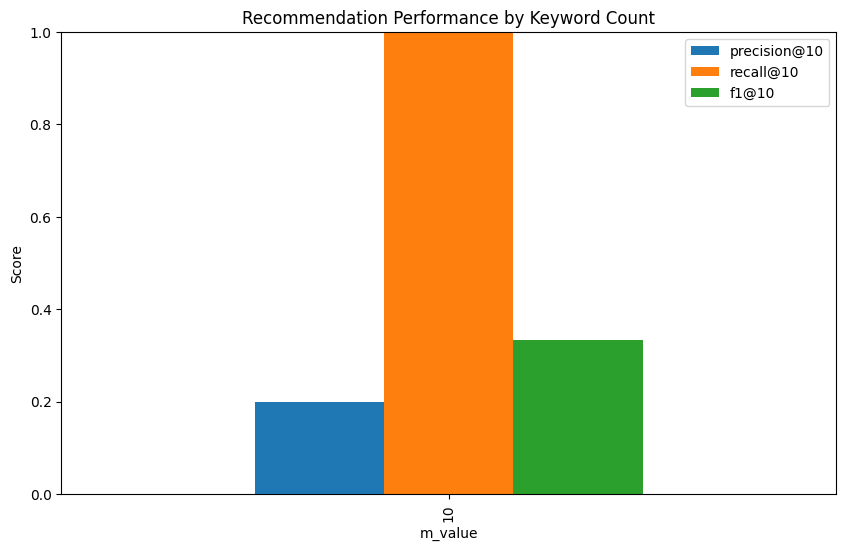

In [54]:
# Check if the user's interest keywords have been hit

y_true = likes
y_pred = [1 for i in range(N)]

if len(y_true) > 0:
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    results.append({
        'm_value': M,
        'topic': topic,
        'precision@10': precision,
        'recall@10': recall,
        'f1@10': f1,
    })
    
eval_results = pd.DataFrame(results)
performance_summary = analyze_results(eval_results)

### Part3-Conclusion and real user's feedback
For real user, the precision@10 and f1@10 is much lower than imagined user, because the taste of real user is not very stable when he just look at the songs across songs of different topics.<br>
My user's feedback: the recommendation is a little hard to use, but I can see it needs a lot of hard work. I tried to choose some songs I may like, but mostly I'm not very interested.